In [6]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import label,regionprops
from PIL import Image
import os

In [7]:
def image_directory(time, slice):
    image_dir = 'entry' + str(time).zfill(4) + '_no_extpag_db0100_vol_' + str(slice).zfill(6) + '.tiff'
    dir = os.path.join(time_directory(time), image_dir)
    return dir

def time_directory(time):
    time_dir = 'entry' + str(time).zfill(4) + '_no_extpag_db0100_vol'
    return time_dir

Conditions on particle **shape** and **dimensions** should be implemented. In addition we should define precisely **how many particles** to segment.

In [17]:
def isAgglomerate(rps, i, smallest_area, eccentricity):
    # Check if the region is too small
    if rps[i].area < smallest_area:
        return False
    # Check if the region is rounded (axis_major_length vs axis_minor_length) (area vs area_convex) (axis_major_length vs equivalent_diameter_area)
    if rps[i].eccentricity > eccentricity:
        return False
    return True

In [27]:
def print_segmented_image(exp, time, slice, threshold=0.55, n_agglomerates=50, smallest_area=5, eccentricity=0.99, save=False):
    
    parent_dir = 'Z:\\Reconstructions\\' + exp
    os.chdir(parent_dir)

    image = Image.open(image_directory(time, slice))
    image = np.array(image)
    image = (image - np.min(image))/(np.max(image) - np.min(image))

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    axes[0].imshow(image, cmap='Greys_r')

    mask = image > threshold
    mask_labeled = np.vectorize(label, signature='(n,m)->(n,m)')(mask)

    rps = regionprops(mask_labeled)
    areas = [r.area for r in rps]
    ordered_areas = np.sort(areas)[::-1]
    idxs = np.argsort(areas)[::-1]
    new_mask = np.zeros_like(mask_labeled)
    for i in idxs[:n_agglomerates]:
        if isAgglomerate(rps, i, smallest_area, eccentricity):
            new_mask[tuple(rps[i].coords.T)] = i + 1
    uniform = np.copy(new_mask)
    uniform[uniform > 0] = 1
    axes[1].imshow(uniform, cmap='Greys_r')
    colored = np.copy(new_mask)
    colored[colored > 0] = colored[colored > 0] + n_agglomerates/10
    axes[2].imshow(colored, cmap='nipy_spectral')
    fig.suptitle(str(exp) + ', time=' + str(time).zfill(4) + ', slice=' + str(slice).zfill(6) + ', threshold=' + str(threshold) + ', agglomerates=' + str(n_agglomerates))
    if save:
        plt.savefig(str(exp) + '_' + str(time).zfill(4) + '_' + str(slice).zfill(6) + '_segmented.png', dpi=600)

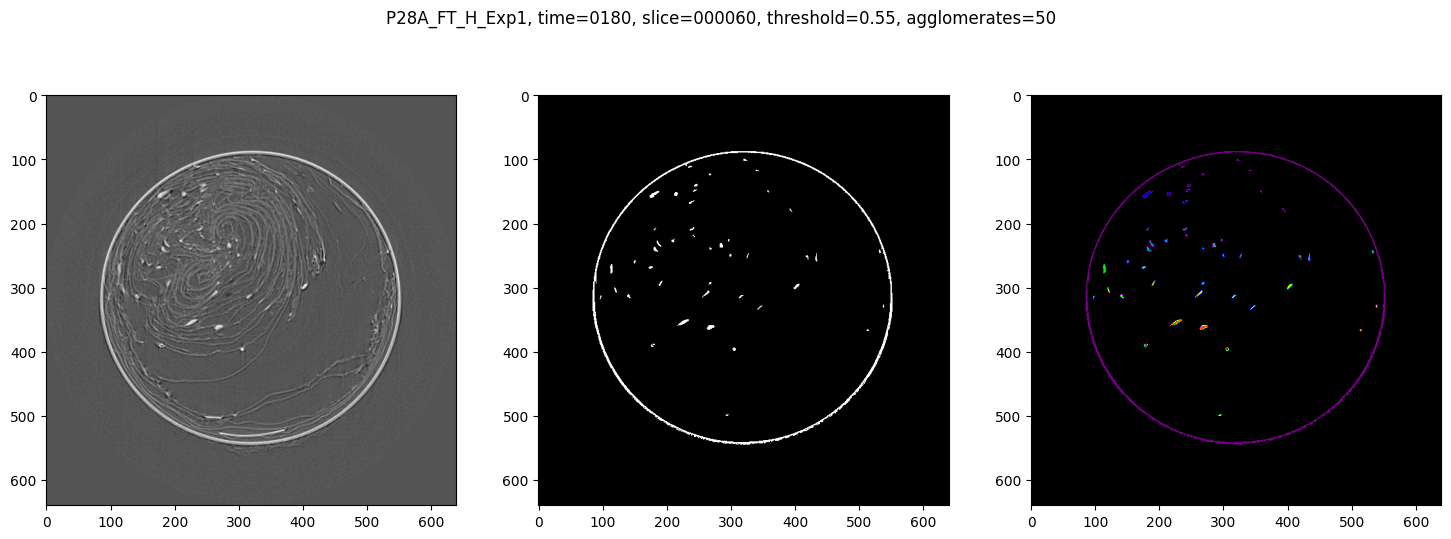

In [28]:
print_segmented_image(exp='P28A_FT_H_Exp1', time=180, slice=60)